# MPII dataset: reading & visualizing annotated data

This jupyter notebook contains code to visualize joints ground truth overlayed on MPII human pose images.
Since MPII annotations exist only for sufficiently separated humans, not all humans in the images have annotations.
The code snippet can also be used to understand how the MPII matlab structure file is read in Python.

Please ensure you have set up the virtual environment `venv_MoveNet_test1` and have it installed in Jupyter Notebook.

Pre-requisites:
Download MPII images from http://human-pose.mpi-inf.mpg.de/#download and paste all images *.jpg in the `/data/mpii/images` folder.

In [3]:
import os
import sys
import copy
from pathlib import Path

import scipy.io
import numpy as np
from tqdm import tqdm
from adjustText import adjust_text
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

Load the text file containing all the image names in the MPII dataset.

In [5]:
root = Path(os.getcwd())
sys.path.append(root)

dataset_name = ['mpii']
dataset_path = list(map(lambda x: os.path.join(root, 'data', x), dataset_name))

# Format of filenames = [[mpii_img_1, mpii_img_2, ... (mpii_img_k)]]
filenames_ = list(map(lambda path, name: open(os.path.join(path, '{}_filenames.txt'.format(name))), dataset_path, dataset_name))
filenames = list(map(lambda f: f.read().split(), filenames_))
_ = list(map(lambda f: f.close(), filenames_))


## Declaring the function for visualizing image and joints

We color code the joints corresponding to the {right, left} + {leg, arm} and the face.

A directory is created to dump the images: `./results/viz_gt/*.jpg`

We then iterate over all: `{image [i], persons [k] in image [i], joint [j] for person [k]}`

In [6]:
def visualize_image(image_info):
    '''
    :param image_info: (dict)
    '''
    colour = {'rankl': (0, 0, 1), 'rknee': (0, 0, 1), 'rhip': (0, 0, 1),
              'lankl': (1, 0, 0), 'lknee': (1, 0, 0), 'lhip': (1, 0, 0),
              'rwri': (1, 1, 0), 'relb': (1, 1, 0), 'rsho': (1, 1, 0),
              'lwri': (0, 1, 0), 'lelb': (0, 1, 0), 'lsho': (0, 1, 0),
              'head': (0, 1, 1), 'thorax': (0, 1, 1), 'upper_neck': (0, 1, 1)}

    os.makedirs(os.path.join(root, 'results', 'viz_gt'), exist_ok=True)
    img_dump = os.path.join(root, 'results', 'viz_gt')

    # Since we're considering only MPII, the outer loop will execute only once.
    for dataset_name_ in image_info.keys():
        # Iterate over all images
        for i in tqdm(range(len(image_info[dataset_name_]['img']))):

            fig, ax = plt.subplots(nrows=1, ncols=1, frameon=False)
            ax.set_axis_off()

            # Load image, gt for the given index
            img = image_info[dataset_name_]['img'][i]
            img_name = image_info[dataset_name_]['img_name'][i]
            img_gt = image_info[dataset_name_]['img_gt'][i]

            # Store joint names which will be displayed on the image
            text_overlay = []
            ax.imshow(img)

            # Color-code the joint and joint name onto the image
            joint_names = list(colour.keys())
            for jnt in joint_names:
                for jnt_gt in img_gt[jnt]:
                    if jnt_gt[2]:
                        text_overlay.append(ax.text(x=jnt_gt[0], y=jnt_gt[1], s=jnt, color=colour[jnt], fontsize=6))
                        ax.add_patch(Circle(jnt_gt[:2], radius=1.5, color=colour[jnt], fill=False))

            # Ensure no crowding of joints on the image
            adjust_text(text_overlay)

            plt.savefig(fname=os.path.join(img_dump, '{}'.format(img_name)),
                        facecolor='black', edgecolor='black', bbox_inches='tight', dpi=300)

            plt.close()
            del fig, ax

## Preparing the images and ground truth

The index to joint name conversion is provided on MPII website.

We load `batch = 200` images at a time to prevent exhausting available RAM.

The subsequent `for` loop(s) are used to unravel the matlab structure file to obtain the joint ground truths.

**Runtime interrupted because it would take too long to finish processig all 24984 images; however, the code is functional and some outputs are available for viewing at `./results/viz_gt/*.jpg`.**

 80%|████████████████████████████████▌        | 159/200 [00:05<00:01, 25.02it/s]

Could not load filename: 040348287.jpg
Could not load filename: 013401523.jpg
Could not load filename: 002878268.jpg


 35%|██████████████▋                           | 45/129 [02:24<04:30,  3.22s/it]


KeyboardInterrupt: 

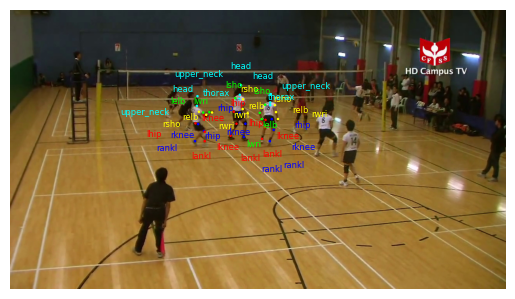

In [7]:
# index to joint name conversion
mpii_idx_to_jnt = {0: 'rankl', 1: 'rknee', 2: 'rhip', 5: 'lankl', 4: 'lknee', 3: 'lhip',
                   6: 'pelvis', 7: 'thorax', 8: 'upper_neck', 11: 'relb', 10: 'rwri', 9: 'head',
                   12: 'rsho', 13: 'lsho', 14: 'lelb', 15: 'lwri'}

# This template will then be updated as and when we read ground truth
mpii_template = dict([(mpii_idx_to_jnt[i], []) for i in range(16)])

# Load the mat file.
matlab_mpii = scipy.io.loadmat(os.path.join(dataset_path[0], 'joints.mat'), struct_as_record=False)['RELEASE'][0, 0]
num_images = annotation_mpii = matlab_mpii.__dict__['annolist'][0].shape[0]

# Load images and GT in batches of 200
initial_index = 0
batch = 200
while initial_index < num_images:
    # Initialize empty placeholder
    img_dict = {'mpii': {'img': [], 'img_name': [], 'img_pred': [], 'img_gt': []}}
    
    # Iterate over each image
    for img_idx in tqdm(range(initial_index, min(initial_index + batch, num_images))):
        annotation_mpii = matlab_mpii.__dict__['annolist'][0, img_idx]
        train_test_mpii = matlab_mpii.__dict__['img_train'][0, img_idx].flatten()[0]
        person_id = matlab_mpii.__dict__['single_person'][img_idx][0].flatten()

        # Load the individual image. Throw an exception if image corresponding to filename not available.
        img_name = annotation_mpii.__dict__['image'][0, 0].__dict__['name'][0]
        try:
            image = plt.imread(os.path.join(dataset_path[0], 'images', img_name))
        except FileNotFoundError:
            print('Could not load filename: {}'.format(img_name))
            continue

        # Avoid modifying the template and create a copy
        gt_per_image = copy.deepcopy(mpii_template)

        # Flag is set to true if atleast one person exists in the image with joint annotations.
        # If Flag == True, then the image and GT is considered for visualization, else skip
        annotated_person_flag = False
        
        # Iterate over persons
        for person in (person_id - 1):
            try:
                annopoints_img_mpii = annotation_mpii.__dict__['annorect'][0, person].__dict__['annopoints'][0, 0]
                num_joints = annopoints_img_mpii.__dict__['point'][0].shape[0]

                # Iterate over present joints
                for i in range(num_joints):
                    x = annopoints_img_mpii.__dict__['point'][0, i].__dict__['x'].flatten()[0]
                    y = annopoints_img_mpii.__dict__['point'][0, i].__dict__['y'].flatten()[0]
                    id_ = annopoints_img_mpii.__dict__['point'][0, i].__dict__['id'][0][0]
                    vis = annopoints_img_mpii.__dict__['point'][0, i].__dict__['is_visible'].flatten()

                    # No entry corresponding to visible
                    if vis.size == 0:
                        vis = 1
                    else:
                        vis = vis.item()

                    gt_per_joint = np.array([x, y, vis]).astype(np.float16)
                    gt_per_image[mpii_idx_to_jnt[id_]].append(gt_per_joint)

                annotated_person_flag = True
            except KeyError:
                # Person 'x' could not have annotated joints, hence move to person 'y'
                continue

        if not annotated_person_flag:
            continue

        # Update the template copy with image, name and ground truth
        img_dict['mpii']['img'].append(image)
        img_dict['mpii']['img_name'].append(img_name)
        img_dict['mpii']['img_gt'].append(gt_per_image)
    
    visualize_image(img_dict)
    initial_index += batch